In [119]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev
from jax import random
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from celluloid import Camera
import time


class Visualization:
    def __init__(self, X_opt, cost, lb, ub):
        self.X_opt = X_opt
        self.cost = cost
        self.lb = lb
        self.ub = ub

        self.f = plt.figure(figsize=(12, 8))
        plt.rc('axes', linewidth=2)

        x = np.arange(lb, ub, 0.1)
        self.X, self.Y = np.meshgrid(x, x)
        M = {0: self.X, 1: self.Y}
        self.F = self.cost(M)

    def plot_optimization(self):
        plt.plot([self.X_opt[i][0] for i in range(len(self.X_opt))],
                 [self.X_opt[i][1] for i in range(len(self.X_opt))], '-*', 
                 alpha=0.5, color='white', markersize=15, lw=2.0)
        plt.contourf(self.X, self.Y, self.F)
        plt.xlabel('$x_1$', size=25)
        plt.ylabel('$x_2$', size=25)
        plt.show()
        # f.savefig("steepest_descent_armijo.pdf", bbox_inches='tight')

    def animate_optimization_2D(self):
        
        camera = Camera(plt.figure(figsize=(10, 8)))

        # plot contour of the function
        # plt.contour(X, Y, F)
        # policy
        x1 = [X_opt[i][0] for i in range(len(X_opt))]
        x2 = [X_opt[i][1] for i in range(len(X_opt))]
        
        for i in range(len(x1)):
            plt.contourf(X, Y, F)
            plt.plot(x1[0], x2[0], '*', color='white', markersize=20, lw=2.0, alpha=0.5)
            x1data, x2data = x1[:i+1], x2[:i+1]
            plt.plot(x1data, x2data, '-', color='white', markersize=10, lw=2.0)
            plt.plot(x1data[-1], x2data[-1], 'o', color='white', markersize=15, lw=2.0, alpha=0.5)
            plt.text(1.0, 1.75, r'iteration: {}'.format(len(x1data)), fontsize=18)        
            plt.xlabel('$x_1$', size=25)
            plt.ylabel('$x_2$', size=25)
            camera.snap()


        anim = camera.animate(blit=True)
        anim.save('optimization_animation.gif', writer='imagemagick')
        plt.show()

    def animate_optimization_3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        camera = Camera(plt.figure(figsize=(10, 8)))

        x1 = [X_opt[i][0] for i in range(len(X_opt))]
        x2 = [X_opt[i][1] for i in range(len(X_opt))]

        for i in range(len(x1)):
            plt.contour(X, Y, F)
            plt.plot(x1[0], x2[0], '*', color='red', markersize=20, lw=2.0, alpha=0.5)
            x1data, x2data = x1[:i+1], x2[:i+1]
            plt.plot(x1data, x2data, '-', color='red', markersize=10, lw=2.0)
            plt.plot(x1data[-1], x2data[-1], 'o', color='red', markersize=10, lw=2.0)
            plt.xlabel('$x_1$', size=25)
            plt.ylabel('$x_2$', size=25)
            camera.snap()

        anim = camera.animate(blit=True)
        anim.save('optimization_animation.gif', writer='imagemagick')
        plt.show()




class UnconstrainedOptimization:
    def __init__(self, cost, direction_type, stepsize_type, x0,
                 termination_params, algo_params=None):
        self.cost = cost
        self.x0 = jnp.array(x0)
        self.direction_type = direction_type
        self.stepsize_type = stepsize_type
        self.algo_params = algo_params
        self.termination_params = termination_params

    def armijo_condition(self, alpha, sigma, x_current, x_next, direction):
        LHS = self.cost(x_current) - self.cost(x_next)
        RHS = - sigma * alpha * jnp.matmul(grad(self.cost)(x_current), direction)
        condition = True if (LHS >= RHS) else False
        return condition

    def get_step_size(self, x_current, direction):

        if self.stepsize_type == 'minimization_rule':
            # create symbolic step size: alpha
            alpha = sym.Symbol('alpha')
            # convert jax device array to numpy list
            x_current = x_current.tolist()
            direction = direction.tolist()
            sym_vec = []
            for d in range(len(direction)):
                mm = x_current[d] + alpha * direction[d]
                sym_vec.append(mm)
            sym_cost = self.cost(sym_vec)
            sym_derivative = sym.diff(sym_cost, alpha)
            alpha_sym = sym.solveset(sym_derivative, alpha)
            alpha_sym = list(alpha_sym)

            # only keep the real number by checking data type
            i = 0
            while True:
                condition = type(alpha_sym[i] ** 2) is sym.numbers.Float
                if condition is True:
                    val = alpha_sym[i]
                    break
                else:
                    i += 1

            alpha = float(val)

        elif self.stepsize_type == 'constant':
            alpha = self.algo_params

        elif self.stepsize_type == 'armijo_rule':
            beta, s, sigma = self.algo_params
            m = 0
            condition = False
            while True:
                alpha = pow(beta, m) * s
                x_next = x_current + alpha * direction
                condition = self.armijo_condition(alpha, sigma, x_current, x_next, direction)

                if condition is True:
                    break
                m += 1
        else:
            raise Exception(
                'Unknown step size type, please input one of the following: minimization_tule, constant, armijo rule')

        return alpha

    def get_gradient_direction(self, x_val):
        # get derivative of the cost function
        derivative = grad(self.cost)(x_val)

        if self.direction_type == 'steepest_descent':
            # D in case of steepest descent is identity matrix
            D = jnp.identity(len(x_val))
            direction = - jnp.matmul(D, derivative)

        elif self.direction_type == 'newton_method':
            hessian = jacfwd(jacrev(self.cost))(x_val)
            D = jnp.linalg.inv(hessian)
            direction = - jnp.matmul(D, derivative)

        else:
            raise Exception(
                'Unknown gradient based method, please input one of the following: '
                'steepest_descent, newton_method')

        return direction

    def update(self, x_current, X_opt, error_val, error_cache):

        # update states
        X_opt.append(np.asarray(x_current, dtype=float))
        direction = self.get_gradient_direction(x_current)
        step_size = self.get_step_size(x_current, direction)
        x_next = x_current + step_size * direction
        error_val = x_current - x_next
        error_norm = jnp.linalg.norm(error_val)
        error_cache.append(error_norm)

        return x_next, X_opt, error_norm, error_cache

    def run_algorithm(self):
        """
        Runs the algorithm provided the user with starting and termination conditions,
        If the termination condition is "convergence" then the algorithm runs until convergence
        is achieved upto the desired value, the other termination option is to run the algorithm for
        a fixed number of timesteps.
        :return: X_opt = a matrix with co-ordinates of all the states obtained from running the algorithm
        """

        # get termination conditions from algo_params
        termination_type, termination_condition = self.termination_params

        x_current = self.x0
        X_opt = []
        error_norm = np.inf
        error_cache = []
        fig = plt.figure()

        if termination_type == "convergence":
            while error_norm > termination_condition:
                x_next, X_opt, error_norm, error_cache = self.update(
                    x_current, X_opt, error_norm, error_cache)
                # update state vector
                x_current = x_next

        elif termination_type == "fixed_steps":
            for t in range(termination_condition):
                x_next, X_opt, error_norm, error_cache = self.update(
                    x_current, X_opt, error_norm, error_cache)
                # update state vector
                x_current = x_next

        return X_opt, error_cache

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

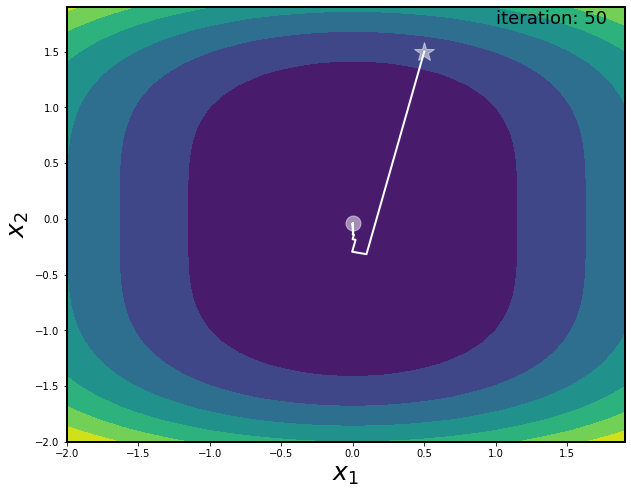

In [125]:

cost = lambda x: 3*pow(x[0], 2) + pow(x[1], 4)


x0 = [0.5, 1.5]
algo_params = 0.10 #[0.5, 1, 0.1]
opt = UnconstrainedOptimization(cost, 'steepest_descent', 'minimization_rule', x0,
                                ['fixed_steps', 50], algo_params)
X_opt, error_cache = opt.run_algorithm()
viz = Visualization(X_opt, cost, -1.5, +1.5)
viz.animate_optimization_2D()


NameError: name 'x1data' is not defined

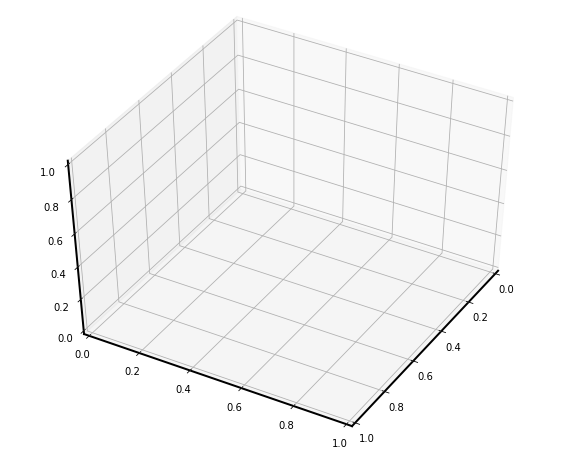

In [73]:
cost = lambda x: 3*pow(x[0], 2) + pow(x[1], 4)

x = np.arange(-2.0, +2.0, 0.1)
X, Y = np.meshgrid(x, x)
M = {0: X, 1: Y}
F = cost(M)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.view_init(45, 30)
camera = Camera(fig)

# plot contour of the function
# plt.contour(X, Y, F)
# policy
x1 = [X_opt[i][0] for i in range(len(X_opt))]
x2 = [X_opt[i][1] for i in range(len(X_opt))]
f_opt = [cost(X_opt[i]) for i in range(len(X_opt))]

ax.scatter3D(x1data[0], x2data[0], f_opt[0], 'o', color='black', lw=2.0)
for i in range(len(x1)):
    x1data, x2data = x1[:i+1], x2[:i+1]
    ax.plot3D(x1data, x2data, f_opt[:i+1], '-', color='black', lw=2.0)
    ax.scatter3D(x1data[-1], x2data[-1], f_opt[-1], 'o', color='black', lw=2.0)
    ax.plot_surface(X, Y, F, rstride=1, cstride=1,
            cmap='viridis', edgecolor='none')

    camera.snap()

anim = camera.animate(blit=True)
anim.save('optimization_animation.gif', writer='imagemagick')
plt.show()